<a href="https://colab.research.google.com/github/panos42/Appliances-Energy-Prediction---UCI-/blob/main/final_project_model_implementations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA PREPROCESSING**

In [ ]:
!pip install boruta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.4 MB/s eta 0:00:00


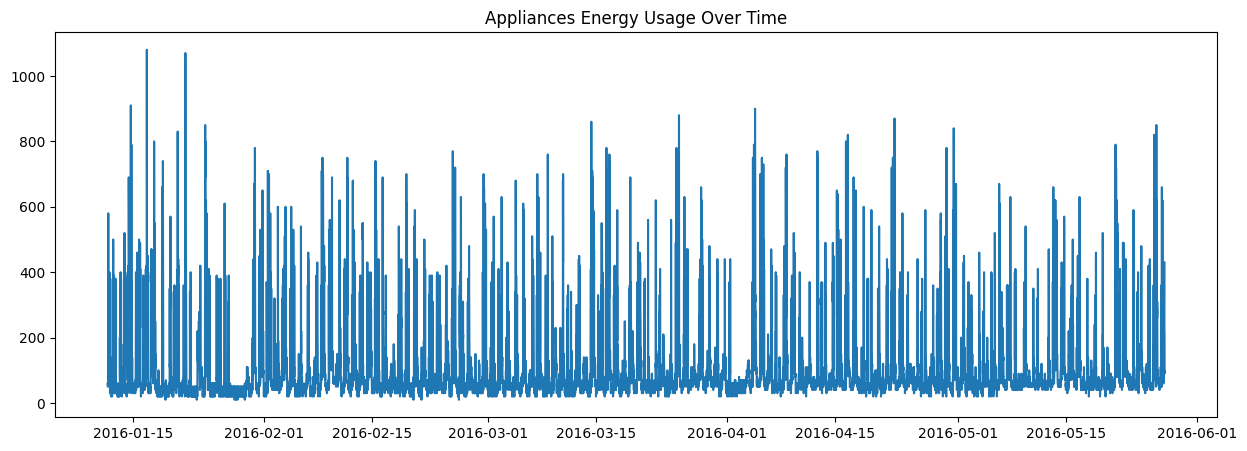

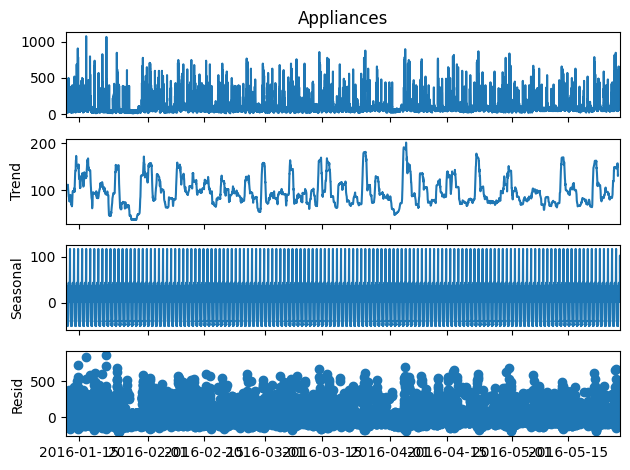

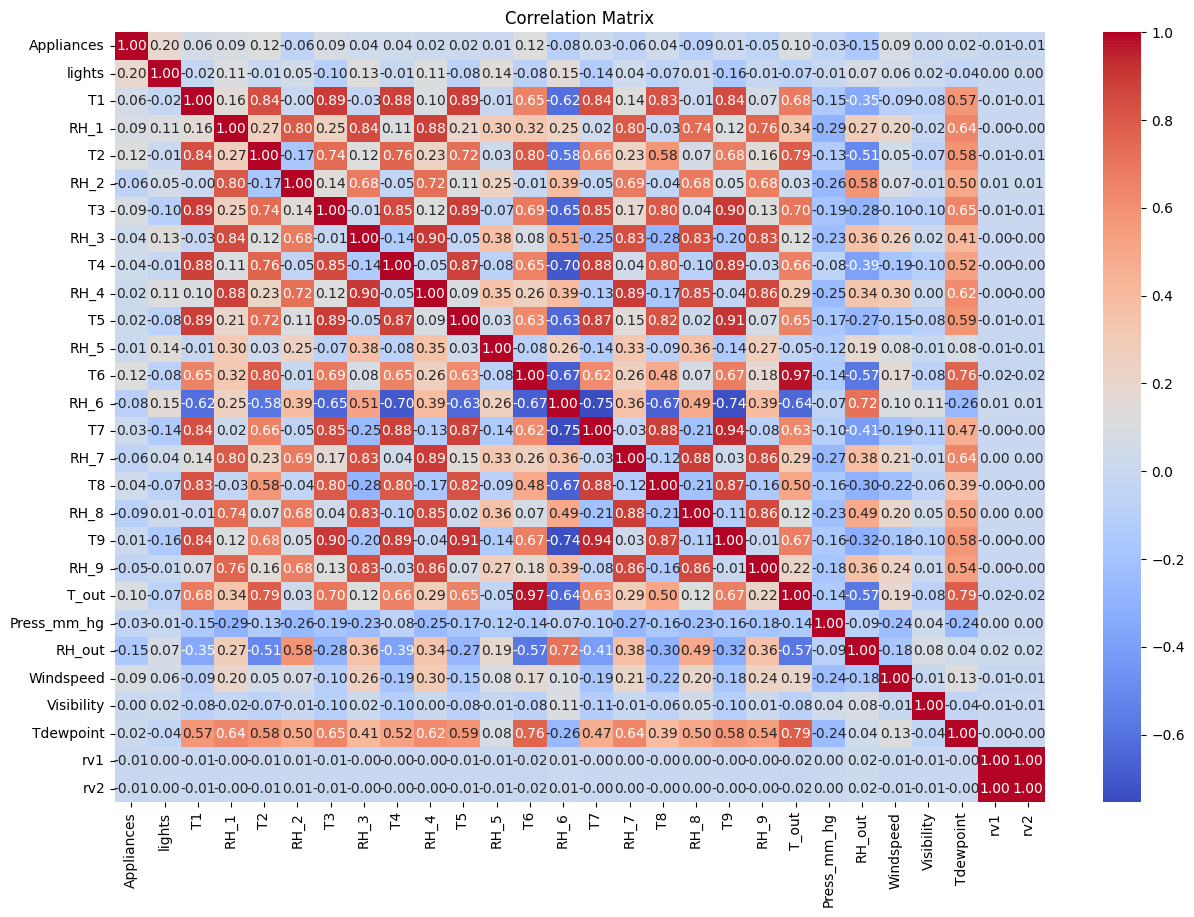

ADF Statistic: -21.6163781980362
p-value: 0.0


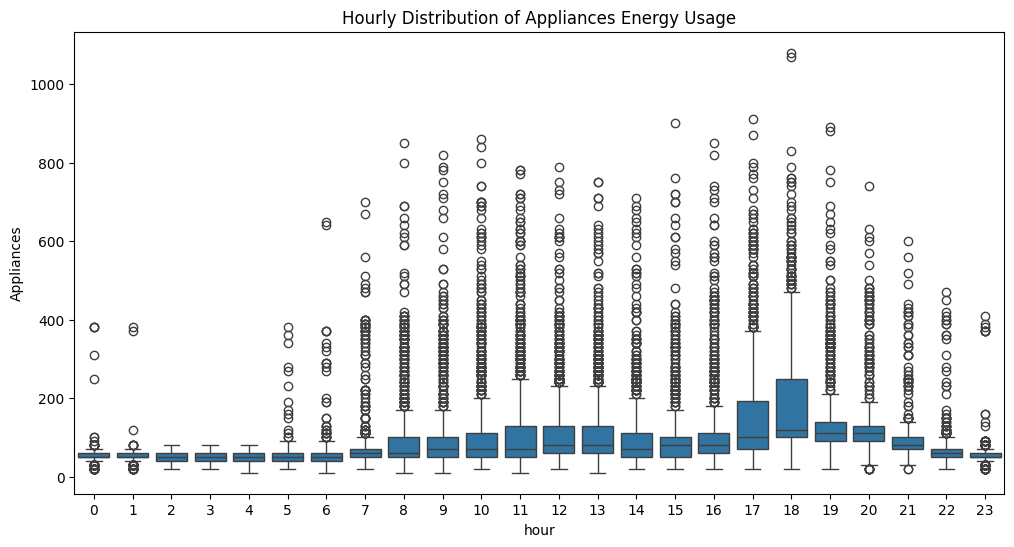

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Load data
df = pd.read_csv('/content/energydata_complete.csv')
df['date'] = pd.to_datetime(df['date'])

# Data cleaning
def clean_data(df):
   df = df.dropna()
   df = df.drop_duplicates()
   return df

df = clean_data(df)

# Outlier detection
def detect_outliers(df, column):
   Q1 = df[column].quantile(0.25)
   Q3 = df[column].quantile(0.75)
   IQR = Q3 - Q1
   outliers = df[(df[column] < Q1 - 1.5*IQR) | (df[column] > Q3 + 1.5*IQR)]
   return outliers

# Example for Appliances
outliers_appliances = detect_outliers(df, 'Appliances')

# Scaling
numeric_cols = df.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_cols]), columns=numeric_cols)

# Time series visualization
plt.figure(figsize=(15,5))
plt.plot(df['date'], df['Appliances'])
plt.title('Appliances Energy Usage Over Time')
plt.show()

# Decomposition
decomposition = seasonal_decompose(df.set_index('date')['Appliances'], period=144)
decomposition.plot()
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Stationarity check
def check_stationarity(series):
   result = adfuller(series)
   print('ADF Statistic:', result[0])
   print('p-value:', result[1])

check_stationarity(df['Appliances'])

# Seasonality
df['hour'] = df['date'].dt.hour
plt.figure(figsize=(12,6))
sns.boxplot(x='hour', y='Appliances', data=df)
plt.title('Hourly Distribution of Appliances Energy Usage')
plt.show()

# **Boruta Package for better feature selection**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the dataset
file_name = "energydata_complete.csv"
df = pd.read_csv(file_name)

# Add two random variables
np.random.seed(42)
df['random1'] = np.random.rand(len(df))
df['random2'] = np.random.rand(len(df))

# Drop unnecessary columns (e.g., 'date' is non-numeric and not predictive)
df = df.drop(columns=['date'])

# Define X (features) and y (target variable: Appliances)
X = df.drop(columns=['Appliances'])
y = df['Appliances']

# Step 1: Apply Boruta for Feature Selection
# Random Forest as the estimator
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
boruta = BorutaPy(estimator=rf, n_estimators='auto', random_state=42)

# Fit Boruta
print("Running Boruta feature selection...")
boruta.fit(X.values, y.values)

# Selected features from Boruta
selected_features = X.columns[boruta.support_].tolist()
print("Selected Features by Boruta:", selected_features)

# Step 2: Transform categorical variables into dummy variables
# (Assume WeekStatus and Day_of_Week are categorical columns)
categorical_columns = ['WeekStatus', 'Day_of_Week']  # Replace with actual categorical columns if present
if set(categorical_columns).issubset(df.columns):
    X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Step 3: Apply Recursive Feature Elimination (RFE)
# Filter X to only include features selected by Boruta
X_selected = X[selected_features]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Perform RFE to find the optimal number of features
print("Running RFE for feature selection...")
rfe = RFE(estimator=rf, n_features_to_select=34)  # Change this value to test other feature counts
rfe.fit(X_train, y_train)

# Selected features from RFE
optimal_features = X_selected.columns[rfe.support_].tolist()
print("Optimal Features by RFE:", optimal_features)

# Step 4: Train and Evaluate Model with Optimal Features
# Train model
rf.fit(X_train[optimal_features], y_train)
y_pred = rf.predict(X_test[optimal_features])

from math import sqrt

# Calculate RMSE manually for older scikit-learn versions
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("RMSE with Optimal Features:", rmse)


# Save final dataset with optimal features
final_df = df[optimal_features + ['Appliances']]
final_df.to_csv("preprocessed_energydata.csv", index=False)
print("Preprocessed dataset saved as preprocessed_energydata.csv")


Running Boruta feature selection...
Selected Features by Boruta: ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Tdewpoint']
Running RFE for feature selection...


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=34 > n_features=23. There will be no feature selection and all features will be kept.
  warnings.warn(


Optimal Features by RFE: ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Tdewpoint']
RMSE with Optimal Features: 67.80952167792043
Preprocessed dataset saved as preprocessed_energydata.csv


GBM MODEL IMPLEMENTATION


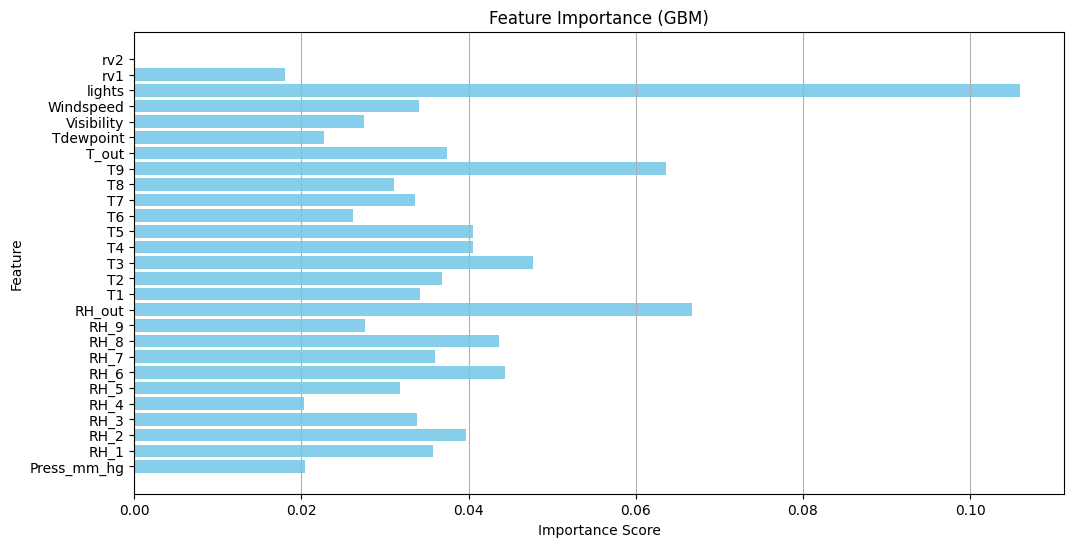

In [ ]:
importance = gbm_model.feature_importances_
plt.figure(figsize=(12, 6))
plt.barh(features, importance, color='skyblue')
plt.title('Feature Importance (GBM)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(True, axis='x')
plt.show()


             Press_mm_hg      RH_1      RH_2      RH_3      RH_4      RH_5  \
Press_mm_hg     1.000000 -0.293957 -0.255646 -0.233274 -0.250748 -0.119327   
RH_1           -0.293957  1.000000  0.797535  0.844677  0.880359  0.303258   
RH_2           -0.255646  0.797535  1.000000  0.678326  0.721435  0.250271   
RH_3           -0.233274  0.844677  0.678326  1.000000  0.898978  0.375422   
RH_4           -0.250748  0.880359  0.721435  0.898978  1.000000  0.352591   
RH_5           -0.119327  0.303258  0.250271  0.375422  0.352591  1.000000   
RH_6           -0.065814  0.245126  0.389933  0.514912  0.392178  0.263797   
RH_7           -0.265850  0.801122  0.690584  0.832685  0.894301  0.325808   
RH_8           -0.225591  0.736196  0.679777  0.828822  0.847259  0.359840   
RH_9           -0.183739  0.764001  0.676467  0.833538  0.856591  0.272197   
RH_out         -0.092017  0.274126  0.584911  0.356192  0.336813  0.185941   
T1             -0.150574  0.164006 -0.002509 -0.028550  0.097861

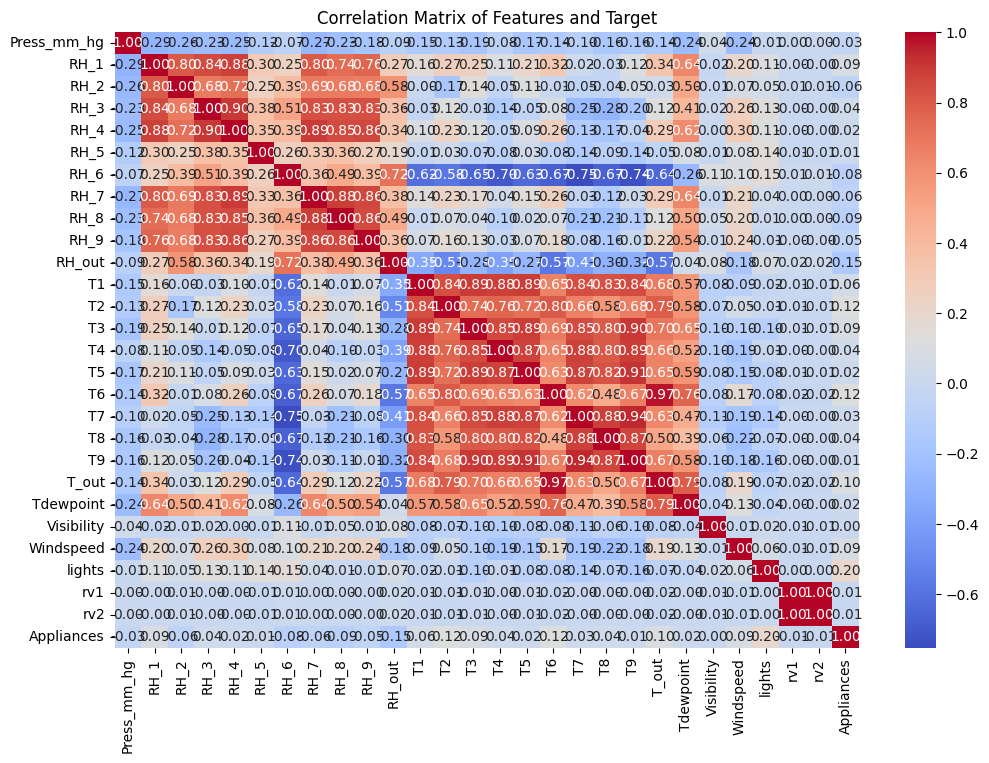

In [ ]:
# Include the target variable in the dataset
data_with_target = data[features.tolist() + [target]]

# Compute the correlation matrix
correlation_matrix = data_with_target.corr()

# Display the correlation matrix
print(correlation_matrix)

import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Features and Target")
plt.show()


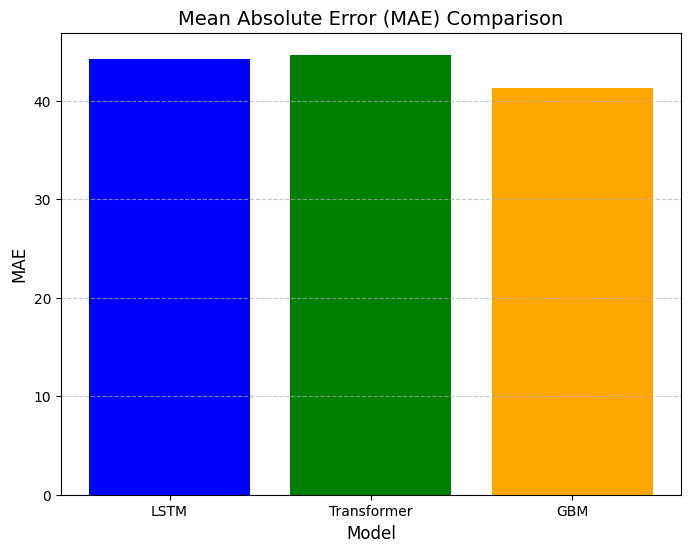

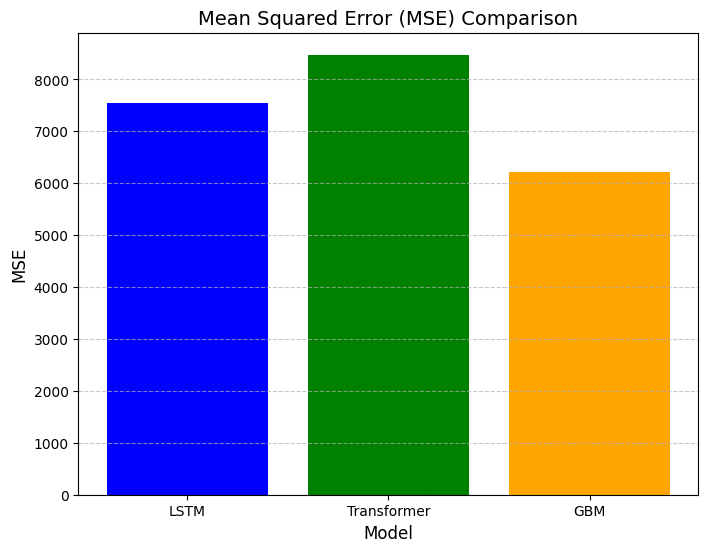

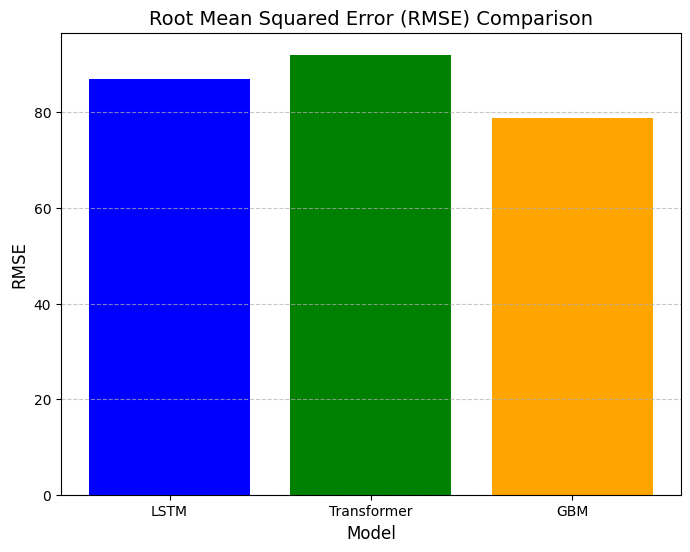

In [ ]:
import matplotlib.pyplot as plt

# Metrics for LSTM, Transformer, and GBM
models = ['LSTM', 'Transformer', 'GBM']
mae_values = [mae, mae_transformer, mae_gbm]
mse_values = [mse, mse_transformer, mse_gbm]
rmse_values = [rmse, rmse_transformer, rmse_gbm]

# Plot MAE comparison
plt.figure(figsize=(8, 6))
plt.bar(models, mae_values, color=['blue', 'green', 'orange'])
plt.title('Mean Absolute Error (MAE) Comparison', fontsize=14)
plt.ylabel('MAE', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot MSE comparison
plt.figure(figsize=(8, 6))
plt.bar(models, mse_values, color=['blue', 'green', 'orange'])
plt.title('Mean Squared Error (MSE) Comparison', fontsize=14)
plt.ylabel('MSE', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot RMSE comparison
plt.figure(figsize=(8, 6))
plt.bar(models, rmse_values, color=['blue', 'green', 'orange'])
plt.title('Root Mean Squared Error (RMSE) Comparison', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# **Plots to showcase the results**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# Load the dataset
file_path = "energydata_complete.csv"
data = pd.read_csv(file_path)

# Convert 'date' column to datetime and set as index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Define features (X) and target (y)
X = data.drop(columns=['Appliances'])  # All columns except 'Appliances'
y = data['Appliances']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print the metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r_squared}")
print(f"MAPE: {mape}%")


RMSE: 78.93277400737922
MAE: 41.57632064819336
R^2: 0.3774031400680542
MAPE: 46.306204720360746%


# **XGBoost Hyperparameter Tuning (Varying n_estimators)**

RMSE for different n_estimators:
   n_estimators       RMSE
0            50  82.375682
1           500  70.595621
2          1000  67.639793
3          5000  65.119984
4         10000  65.029410


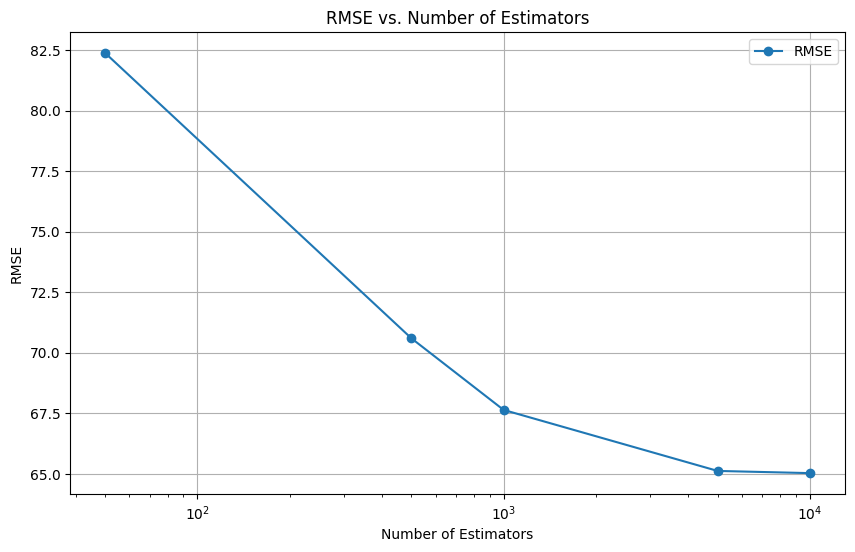

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Load the dataset
file_path = "energydata_complete.csv"
data = pd.read_csv(file_path)

# Convert 'date' column to datetime and set as index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Define features (X) and target (y)
X = data.drop(columns=['Appliances'])  # All columns except 'Appliances'
y = data['Appliances']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a fixed learning rate and other parameters
learning_rate = 0.1
max_depth = 5

# Define a larger range of n_estimators
n_estimators_list = [50, 500, 1000, 5000, 10000]

# Initialize a list to store RMSE results
results = []

# Iterate through the list of n_estimators
for n_est in n_estimators_list:
    model = XGBRegressor(learning_rate=learning_rate, n_estimators=n_est, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Append the results
    results.append({'n_estimators': n_est, 'RMSE': rmse})

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)

# Print the results
print("RMSE for different n_estimators:")
print(results_df)

# Plot RMSE vs. n_estimators
plt.figure(figsize=(10, 6))
plt.plot(results_df['n_estimators'], results_df['RMSE'], marker='o', label='RMSE', linestyle='-')
plt.title('RMSE vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.xscale('log')  # Use a logarithmic scale for large jumps
plt.grid()
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
RMSE for different GRU units:
   GRU_units       RMSE
0         16  91.335224
1         32  91.177053
2         64  90.606423
3        128  91.136500
4        256  92.397679
5        512  91.414687
6       1024  90.677376


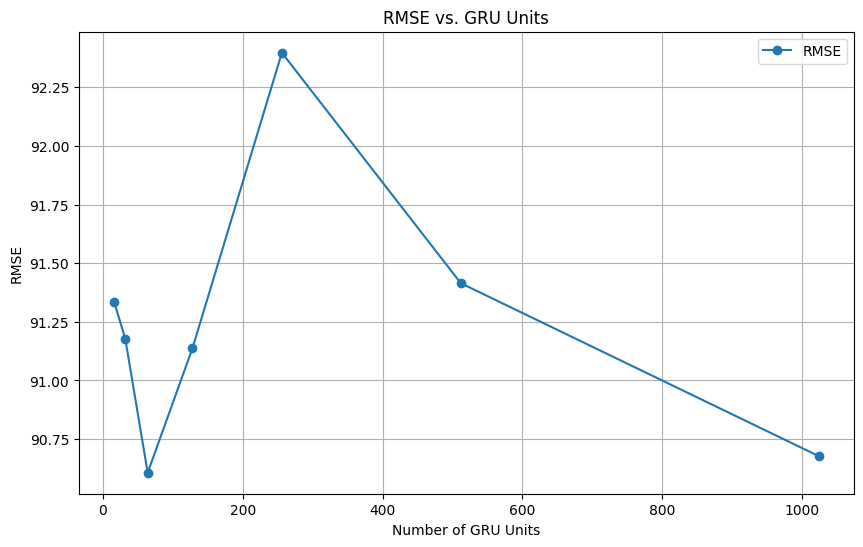

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

# Load the dataset
file_path = "energydata_complete.csv"
data = pd.read_csv(file_path)

# Convert 'date' column to datetime and set as index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Define features (X) and target (y)
X = data.drop(columns=['Appliances'])  # All columns except 'Appliances'
y = data['Appliances']

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Reshape for GRU (samples, timesteps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Define different numbers of GRU units to test
gru_units_list = [16, 32, 64, 128, 256,512,1024]

# Initialize a list to store RMSE results
results = []

# Iterate through different numbers of GRU units
for units in gru_units_list:
    # Define the GRU model
    model = Sequential([
        GRU(units, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1)  # Single output for regression
    ])

    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Inverse transform the predictions and ground truth
    y_pred = scaler_y.inverse_transform(y_pred)
    y_test_rescaled = scaler_y.inverse_transform(y_test)

    # Evaluate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred))

    # Append the results
    results.append({'GRU_units': units, 'RMSE': rmse})

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)

# Print the results
print("RMSE for different GRU units:")
print(results_df)

# Plot RMSE vs. GRU units
plt.figure(figsize=(10, 6))
plt.plot(results_df['GRU_units'], results_df['RMSE'], marker='o', label='RMSE', linestyle='-')
plt.title('RMSE vs. GRU Units')
plt.xlabel('Number of GRU Units')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


  1/124 ━━━━━━━━━━━━━━━━━━━━ 31s 255ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 32/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 30/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 33/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 33/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 30/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 33/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 28/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 24/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RMSE for different Transformer configurations:
   num_heads  d_model        RMSE
0          2       16   92.878378
1          2       32  103.933017
2          2       64   93.171683
3          4       16   92.840676
4          4       32   94.702260
5          4       64   89.647514
6          8       16   91.727296
7          8       32   96.602183
8          8       64   92.021369


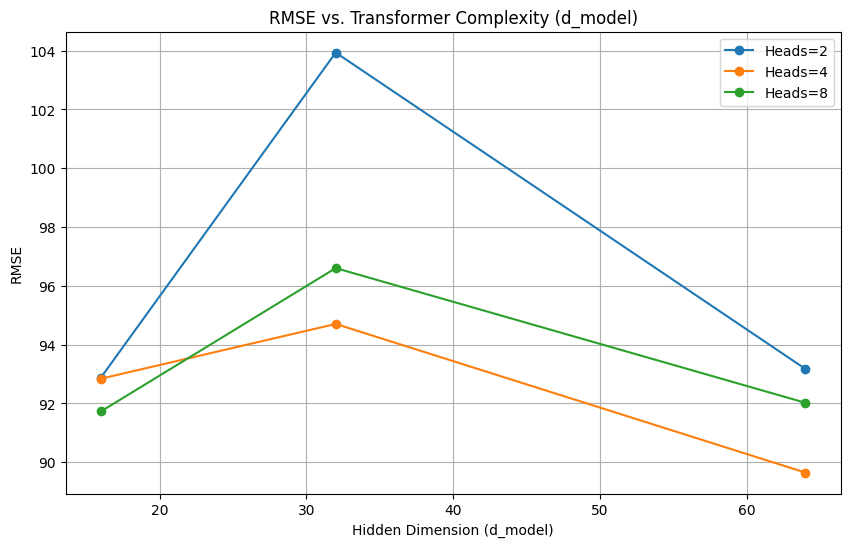

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add, Flatten
import matplotlib.pyplot as plt

# Load the dataset
file_path = "energydata_complete.csv"
data = pd.read_csv(file_path)

# Convert 'date' column to datetime and set as index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Define features (X) and target (y)
X = data.drop(columns=['Appliances'])  # All columns except 'Appliances'
y = data['Appliances']

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Reshape for Transformer (samples, timesteps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Define a custom Transformer model
def transformer_model(num_heads, d_model, input_shape):
    inputs = Input(shape=input_shape)
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
    attention = Add()([inputs, attention])  # Residual connection
    attention = LayerNormalization(epsilon=1e-6)(attention)

    # Feed-forward layer
    ffn = Dense(d_model, activation='relu')(attention)
    ffn = Dense(input_shape[-1])(ffn)
    ffn = Add()([attention, ffn])  # Residual connection
    ffn = LayerNormalization(epsilon=1e-6)(ffn)

    # Output layer
    flatten = Flatten()(ffn)
    outputs = Dense(1)(flatten)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Define different complexities for the Transformer
num_heads_list = [2, 4, 8]
d_model_list = [16, 32, 64]

# Initialize a list to store RMSE results
results = []

# Iterate through combinations of num_heads and d_model
for num_heads, d_model in [(nh, dm) for nh in num_heads_list for dm in d_model_list]:
    model = transformer_model(num_heads=num_heads, d_model=d_model, input_shape=(X_train.shape[1], X_train.shape[2]))

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Inverse transform the predictions and ground truth
    y_pred = scaler_y.inverse_transform(y_pred)
    y_test_rescaled = scaler_y.inverse_transform(y_test)

    # Evaluate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred))

    # Append the results
    results.append({'num_heads': num_heads, 'd_model': d_model, 'RMSE': rmse})

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)

# Print the results
print("RMSE for different Transformer configurations:")
print(results_df)

# Plot RMSE vs. Transformer complexity
plt.figure(figsize=(10, 6))
for num_heads in num_heads_list:
    subset = results_df[results_df['num_heads'] == num_heads]
    plt.plot(subset['d_model'], subset['RMSE'], marker='o', label=f'Heads={num_heads}')

plt.title('RMSE vs. Transformer Complexity (d_model)')
plt.xlabel('Hidden Dimension (d_model)')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
plt.show()


Model Performance Summary:
         Model  Mean RMSE  Best RMSE
0      XGBoost  70.152098  65.029410
1          GRU  91.249277  90.606423
2  Transformer  94.169375  89.647514


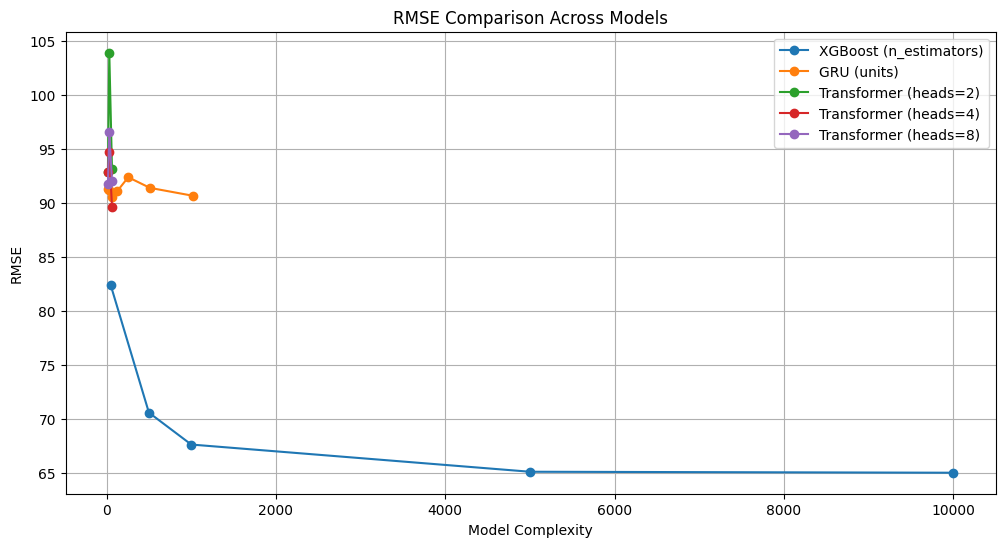

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Results for each model
xgboost_results = pd.DataFrame({'n_estimators': [50, 500, 1000, 5000, 10000],
                                 'RMSE': [82.375682, 70.595621, 67.639793, 65.119984, 65.029410]})

gru_results = pd.DataFrame({'GRU_units': [16, 32, 64, 128, 256, 512, 1024],
                            'RMSE': [91.335224, 91.177053, 90.606423, 91.136500, 92.397679, 91.414687, 90.677376]})

transformer_results = pd.DataFrame({'num_heads': [2, 2, 2, 4, 4, 4, 8, 8, 8],
                                     'd_model': [16, 32, 64, 16, 32, 64, 16, 32, 64],
                                     'RMSE': [92.878378, 103.933017, 93.171683, 92.840676, 94.702260, 89.647514,
                                              91.727296, 96.602183, 92.021369]})

# Calculate mean and best RMSE for each model
xgboost_mean_rmse = xgboost_results['RMSE'].mean()
xgboost_best_rmse = xgboost_results['RMSE'].min()

gru_mean_rmse = gru_results['RMSE'].mean()
gru_best_rmse = gru_results['RMSE'].min()

transformer_mean_rmse = transformer_results['RMSE'].mean()
transformer_best_rmse = transformer_results['RMSE'].min()

# Print summary table
summary = pd.DataFrame({
    'Model': ['XGBoost', 'GRU', 'Transformer'],
    'Mean RMSE': [xgboost_mean_rmse, gru_mean_rmse, transformer_mean_rmse],
    'Best RMSE': [xgboost_best_rmse, gru_best_rmse, transformer_best_rmse]
})

print("Model Performance Summary:")
print(summary)

# Plot RMSE trends
plt.figure(figsize=(12, 6))

# XGBoost
plt.plot(xgboost_results['n_estimators'], xgboost_results['RMSE'], label='XGBoost (n_estimators)', marker='o')

# GRU
plt.plot(gru_results['GRU_units'], gru_results['RMSE'], label='GRU (units)', marker='o')

# Transformer
for num_heads in transformer_results['num_heads'].unique():
    subset = transformer_results[transformer_results['num_heads'] == num_heads]
    plt.plot(subset['d_model'], subset['RMSE'], label=f'Transformer (heads={num_heads})', marker='o')

plt.title('RMSE Comparison Across Models')
plt.xlabel('Model Complexity')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Load the dataset
df = pd.read_csv('energydata_complete.csv')

# List of features selected by Boruta
selected_features = ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5',
                     'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Tdewpoint']

# Define the target variable (Appliances)
target = 'Appliances'

# Separate features and target
X = df[selected_features]
y = df[target]

# Scale the features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train an XGBoost model on the selected features
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE with selected features: {rmse}")


RMSE with selected features: 64.44043246237179


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Load the dataset
df = pd.read_csv('energydata_complete.csv')

# List of features selected by Boruta
selected_features = ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5',
                     'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Tdewpoint']

# Define the target variable (Appliances)
target = 'Appliances'

# Separate features and target
X = df[selected_features]
y = df[target]

# Scale the features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape data to 3D as required by GRU (samples, timesteps, features)
X_train_3d = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_3d = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Build the GRU model
model = Sequential()
model.add(GRU(units=64, return_sequences=False, input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])))
model.add(Dropout(0.2))  # Dropout for regularization
model.add(Dense(units=1))  # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_3d, y_train, epochs=50, batch_size=32, verbose=1)

# Predict on the test set
y_pred = model.predict(X_test_3d)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE with GRU: {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 19759.1172
Epoch 2/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 14836.8535
Epoch 3/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 11167.5684
Epoch 4/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 10475.8018
Epoch 5/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9903.4609
Epoch 6/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9373.9844
Epoch 7/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9714.2344
Epoch 8/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 9353.0576
Epoch 9/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 9208.7793
Epoch 10/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8957.4561
Epoch 11/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8621.8213
Epoch 12/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8723.8447
Epoch 13/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8418.7480
Epoch 14/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8555.7119
Epoch 15/5

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MultiHeadAttention, Dense, Dropout, LayerNormalization, Flatten
from tensorflow.keras.optimizers import Adam

# Load the dataset
df = pd.read_csv('energydata_complete.csv')

# List of features selected by Boruta
selected_features = ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5',
                     'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Tdewpoint']

# Define the target variable (Appliances)
target = 'Appliances'

# Separate features and target
X = df[selected_features]
y = df[target]

# Scale the features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape data to 3D as required by Transformer (samples, timesteps, features)
X_train_3d = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_3d = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Build the Transformer model using the Functional API
def build_transformer(input_shape):
    # Input layer
    inputs = Input(shape=input_shape)

    # Multi-head attention layer
    attention_output = MultiHeadAttention(num_heads=4, key_dim=32)(inputs, inputs)
    attention_output = Dropout(0.2)(attention_output)  # Dropout for regularization
    attention_output = LayerNormalization()(attention_output)

    # Feed-forward layer
    dense_output = Dense(64, activation='relu')(attention_output)
    dense_output = Dropout(0.2)(dense_output)

    # Flatten the output for regression
    flattened_output = Flatten()(dense_output)
    output = Dense(1)(flattened_output)  # Output layer for regression

    # Create and compile the model
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=Adam(), loss='mean_squared_error')

    return model

# Build the model
model = build_transformer(input_shape=(X_train_3d.shape[1], X_train_3d.shape[2]))

# Train the model
model.fit(X_train_3d, y_train, epochs=50, batch_size=32, verbose=1)

# Predict on the test set
y_pred = model.predict(X_test_3d)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE with Transformer: {rmse}")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


494/494 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 15667.8027
Epoch 2/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8822.2891
Epoch 3/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9415.7568
Epoch 4/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9162.2773
Epoch 5/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 8583.8428
Epoch 6/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8239.3418
Epoch 7/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9133.0605
Epoch 8/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8347.9932
Epoch 9/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8197.5596
Epoch 10/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 8292.1182
Epoch 11/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 8856.1172
Epoch 12/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8819.2930
Epoch 13/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8135.8101
Epoch 14/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8151.5864
Epoch 15/50
494/494 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE with Transformer: 87.72039486790544


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 18391.0332
Epoch 2/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11225.0957
Epoch 3/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 10018.7832
Epoch 4/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 9911.9814
Epoch 5/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 9010.4072
Epoch 6/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9098.4688
Epoch 7/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9228.0752
Epoch 8/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8852.9170
Epoch 9/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8686.0801
Epoch 10/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8771.5908
Epoch 11/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8493.9814
Epoch 12/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8200.8232
Epoch 13/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8585.2412
Epoch 14/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8730.8555
Epoch 15/50
494/494 ━━━

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 15366.9287
Epoch 2/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 9037.5068
Epoch 3/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 9446.6074
Epoch 4/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8844.7617
Epoch 5/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8990.6914
Epoch 6/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8166.5864
Epoch 7/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 8529.6670
Epoch 8/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 8917.1270
Epoch 9/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8421.5303
Epoch 10/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8339.5508
Epoch 11/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8456.5742
Epoch 12/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8576.6396
Epoch 13/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8257.7676
Epoch 14/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 8837.3779
Epoch 15/50
494/494 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


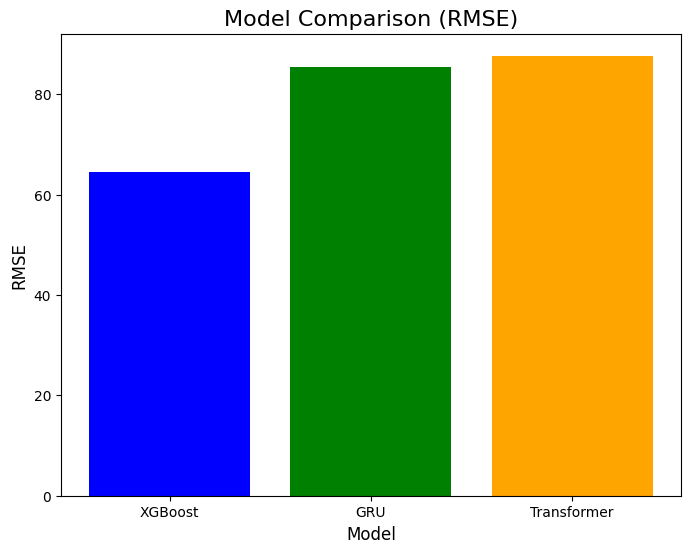

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, MultiHeadAttention, LayerNormalization, Flatten, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# Load the dataset
df = pd.read_csv('energydata_complete.csv')

# List of features selected by Boruta
selected_features = ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5',
                     'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Tdewpoint']

# Define the target variable (Appliances)
target = 'Appliances'

# Separate features and target
X = df[selected_features]
y = df[target]

# Scale the features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape data to 3D as required by GRU and Transformer (samples, timesteps, features)
X_train_3d = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_3d = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# --- XGBoost Model ---
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

# --- GRU Model ---
def build_gru(input_shape):
    model = Sequential()
    model.add(GRU(64, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

gru_model = build_gru(input_shape=(X_train_3d.shape[1], X_train_3d.shape[2]))
gru_model.fit(X_train_3d, y_train, epochs=50, batch_size=32, verbose=1)
gru_pred = gru_model.predict(X_test_3d)
gru_rmse = np.sqrt(mean_squared_error(y_test, gru_pred))

# --- Transformer Model ---
def build_transformer(input_shape):
    inputs = Input(shape=input_shape)
    attention_output = MultiHeadAttention(num_heads=4, key_dim=32)(inputs, inputs)
    attention_output = Dropout(0.2)(attention_output)
    attention_output = LayerNormalization()(attention_output)
    dense_output = Dense(64, activation='relu')(attention_output)
    dense_output = Dropout(0.2)(dense_output)
    flattened_output = Flatten()(dense_output)
    output = Dense(1)(flattened_output)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

transformer_model = build_transformer(input_shape=(X_train_3d.shape[1], X_train_3d.shape[2]))
transformer_model.fit(X_train_3d, y_train, epochs=50, batch_size=32, verbose=1)
transformer_pred = transformer_model.predict(X_test_3d)
transformer_rmse = np.sqrt(mean_squared_error(y_test, transformer_pred))

# --- Results Comparison ---
models = ['XGBoost', 'GRU', 'Transformer']
rmse_values = [xgb_rmse, gru_rmse, transformer_rmse]

# --- Plotting RMSE Comparison ---
plt.figure(figsize=(8, 6))
plt.bar(models, rmse_values, color=['blue', 'green', 'orange'])
plt.title('Model Comparison (RMSE)', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.show()


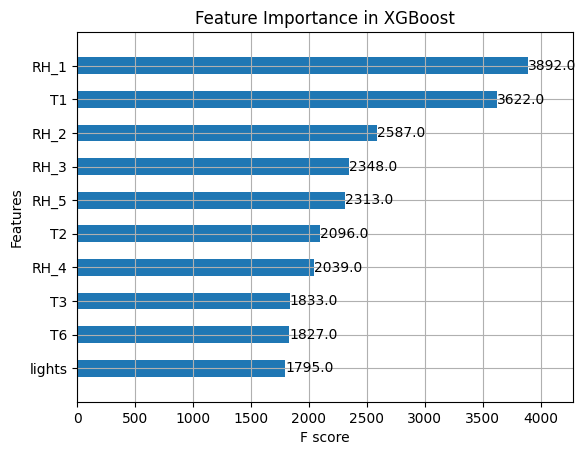

In [ ]:
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt

# Ensure your data (X_train) is a DataFrame with correct column names
X_train = pd.DataFrame(X_train, columns=['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Tdewpoint'])

# Fit your XGBoost model
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Plot feature importance
plot_importance(xgb_model, importance_type='weight', max_num_features=10, height=0.5)
plt.title("Feature Importance in XGBoost")
plt.show()


100%|===================| 15787/15788 [12:41<00:00]       

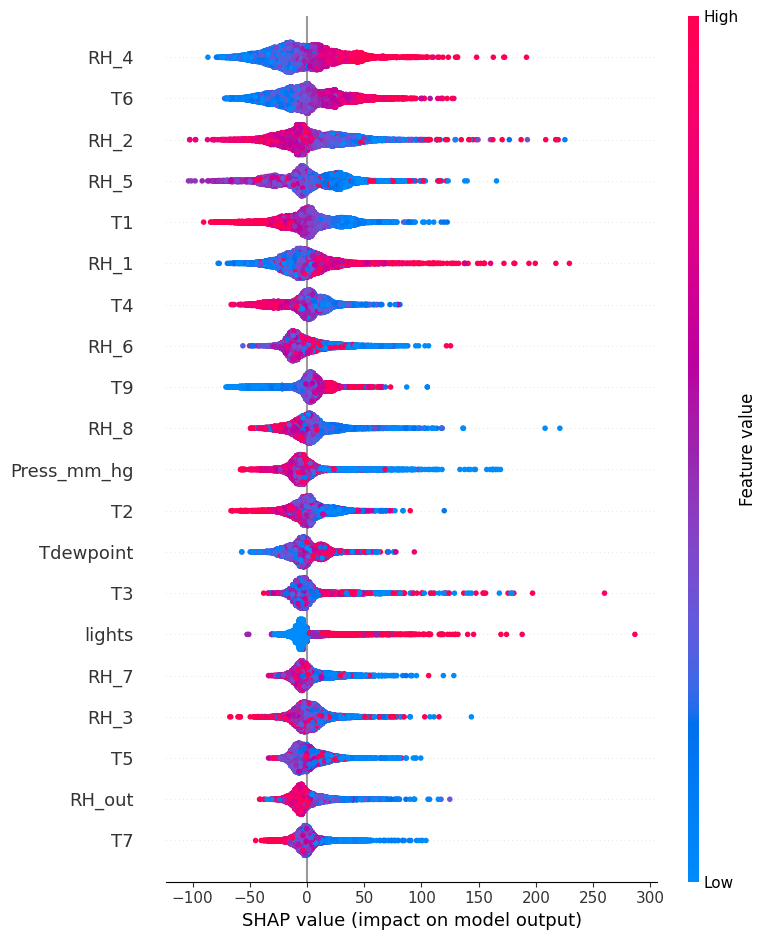

In [ ]:
import shap

# Initialize SHAP Explainer for the XGBoost model
explainer = shap.Explainer(xgb_model, X_train)

# Compute SHAP values
shap_values = explainer(X_train)

# Plot SHAP summary
shap.summary_plot(shap_values, X_train)


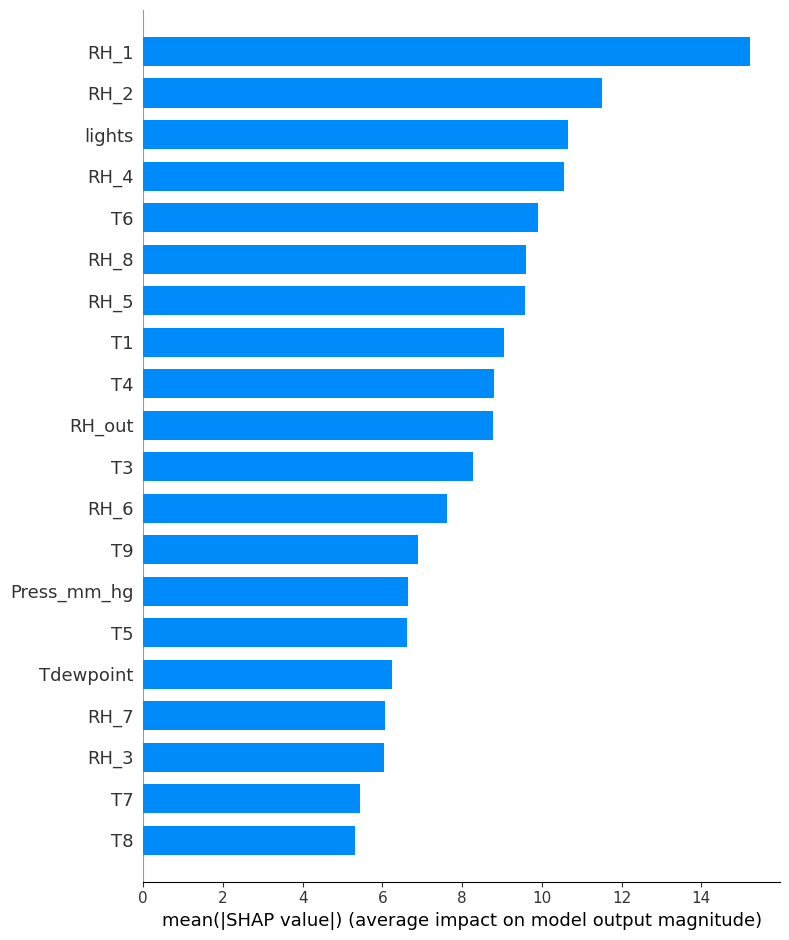

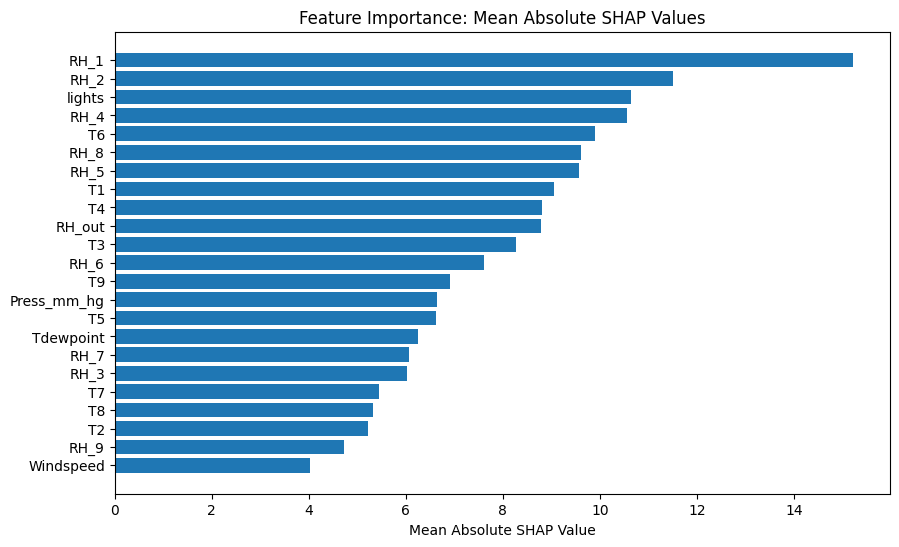

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have an XGBoost model (xgb_model) and X_train
# Calculate SHAP values for the model
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train)

# Calculate the mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values.values).mean(axis=0)

# Create a bar plot for the mean SHAP values
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Alternatively, you can create a custom bar plot:
feature_names = X_train.columns  # If X_train is a pandas DataFrame

# Sort the features by mean SHAP value
sorted_idx = np.argsort(mean_shap_values)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), mean_shap_values[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Feature Importance: Mean Absolute SHAP Values")
plt.show()


In [ ]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
result = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_root_mean_squared_error')

# Plot the permutation importance
importance = result.importances_mean
features = X.columns
sorted_idx = importance.argsort()

plt.barh(features[sorted_idx], importance[sorted_idx])
plt.xlabel("Permutation Importance (Decrease in RMSE)")
plt.title("Permutation Importance for XGBoost")
plt.show()
